In [1]:
%matplotlib notebook
import json
import pandas as pd
import numpy as np
import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pystan

In [2]:
data = json.load(open('matches.json', 'r'))
print(len(data))

39354


# Bets

In [3]:
bets = {}
for d in data:
    if 'tours' in d and len(d['tours']):
        match_id = d['tours'][0]['hltvId']
        
        if match_id == 2310359:
            break
        
        t1_id = d['tourMatches'][0]['teamId1']
        t2_id = d['tourMatches'][0]['teamId2']
        
        t1_score = d['tourMatches'][0]['team1Score']
        t2_score = d['tourMatches'][0]['team2Score']
        
        t1_bets = d['tourBetEvents'][0]['team1Balance']
        t2_bets = d['tourBetEvents'][0]['team2Balance']
        
        if t1_id == d['playerTeams'][0]['id']:
            t1_hltv_id = d['playerTeams'][0]['hltvId']
            t2_hltv_id = d['playerTeams'][1]['hltvId']
        elif t1_id == d['playerTeams'][1]['id']:
            t1_hltv_id = d['playerTeams'][1]['hltvId']
            t2_hltv_id = d['playerTeams'][0]['hltvId']
        else:
            raise Exception('Chablau')
        
        if t1_bets == 0 and t2_bets == 0:
            continue
        
        bets[str(match_id)] = {
            'match_id': str(match_id),
            'team1_id': str(t1_hltv_id),
            'team2_id': str(t2_hltv_id),
            'team1_bets': str(t1_bets),
            'team2_bets': str(t2_bets),
            'team1_score': str(t1_score),
            'team2_score': str(t2_score),
        }
print(len(bets))

7344


# Matches

In [4]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
}
cnt = 0
matches = {d['match_id']: {} for d in data if 'match_id' in d}
for d in data:
    if 'match_id' not in d: continue
    matches[d['match_id']].update(d)
    if 'day' in d:
        matches[d['match_id']]['date'] = d['day']+'/'+str(months[d['month']])+'/'+d['year']

    if d['match_id'] in bets and 'team1_id' in d: 
        if d['team1_id'] == bets[d['match_id']]['team1_id'] and d['team2_id'] == bets[d['match_id']]['team2_id']:
            matches[d['match_id']].update(bets[d['match_id']])
            cnt += 1
print(len(matches), cnt)

13157 7257


In [5]:
for match_id in list(matches.keys()):
    if 'team1_rounds' not in matches[match_id] and 'team1_score' not in matches[match_id]:
        del matches[match_id]
print(len(matches))

13157


## Players

In [6]:
cnt1 = cnt2 = cnt3 = 0
for match_id in list(matches.keys()):
    if 'team1_stats' not in matches[match_id] or 'team2_stats' not in matches[match_id]:
        del matches[match_id]
        cnt1 += 1
    elif len(matches[match_id]['team1_stats']) < 5 or len(matches[match_id]['team2_stats']) < 5:
        del matches[match_id]
        cnt2 += 1
    elif len(matches[match_id]['team1_stats']) > 5 or len(matches[match_id]['team2_stats']) > 5:
        del matches[match_id]
        cnt3 += 1
    else:
        for i, p in enumerate(matches[match_id]['team1_stats'], start=1):
            matches[match_id]['team1_p'+str(i)] = p['player_id']
            matches[match_id]['team1_p'+str(i)+'_name'] = p['player_name']
        for i, p in enumerate(matches[match_id]['team2_stats'], start=1):
            matches[match_id]['team2_p'+str(i)] = p['player_id']
            matches[match_id]['team2_p'+str(i)+'_name'] = p['player_name']

# Cleaning

In [6]:
for k, v in matches.items():
    v.pop('team1_stats', None)
    v.pop('team2_stats', None)
    v.pop('match_page', None)
    v.pop('bets_page', None)
    v.pop('year', None)
    v.pop('day', None)
    v.pop('month', None)

df = pd.DataFrame.from_dict(matches, orient='index')
df.date = pd.to_datetime(df.date)
df = df[df.date > pd.to_datetime('2015-01-01')]
df = df[df.team1_rounds != df.team2_rounds]

teams_matches = pd.concat([df.team1_id, df.team2_id]).value_counts()
teams = list(teams_matches[teams_matches >= 50].index)

df = df[df.team1_id.isin(teams) & df.team2_id.isin(teams)]

In [16]:
len(df)

4224

In [17]:
df_train = df[:int(len(df)*0.8)].copy()
df_test = df[int(len(df)*0.8):].copy()

In [18]:
len(df_train), len(df_test)

(3379, 845)

# Model

In [19]:
code = '''
data {
    int n;
    int n_teams;
    int team1_id[n];
    int team2_id[n];
    int team1_win[n];
}
parameters {
    real skill[n_teams];
    real<lower=0> alpha;
}
model {
    alpha ~ normal(0, 2.5);
    skill ~ normal(0, 1);
    for(i in 1:n){
        team1_win[i] ~ bernoulli_logit((skill[team1_id[i]] - skill[team2_id[i]])*alpha);
    }
}
'''

teams = list(pd.concat([df.team1_id, df.team2_id]).value_counts().index)
data = {
    'n': len(df_train),
    'n_teams': len(teams),
    'team1_id': df_train.team1_id.apply(lambda x: teams.index(x)).values + 1,
    'team2_id': df_train.team2_id.apply(lambda x: teams.index(x)).values + 1,
    'team1_win': (df_train.team1_rounds > df_train.team2_rounds).values.astype('int32')
}
fit = pystan.stan(model_code=code, data=data, iter=10000, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_edd9f69dc5c5290159cbe10d34c4e2d4 NOW.


In [20]:
fit

Inference for Stan model: anon_model_edd9f69dc5c5290159cbe10d34c4e2d4.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
skill[0]    0.25  3.7e-3   0.52  -0.83  -0.08   0.26   0.59   1.23  20000    1.0
skill[1]    0.75  3.7e-3   0.53   -0.3   0.41   0.76    1.1   1.79  20000    1.0
skill[2]    0.69  3.8e-3   0.53  -0.37   0.35    0.7   1.05   1.74  20000    1.0
skill[3]    0.45  3.7e-3   0.53  -0.61   0.11   0.46    0.8   1.48  20000    1.0
skill[4]    0.68  3.9e-3   0.55  -0.42   0.32   0.68   1.04   1.74  20000    1.0
skill[5]  3.9e-3  4.0e-3   0.56  -1.12  -0.36   0.01   0.38   1.09  20000    1.0
skill[6]    0.66  3.8e-3   0.54  -0.42   0.31   0.66   1.01   1.72  20000    1.0
skill[7]    0.17  4.1e-3   0.58   -1.0   -0.2   0.18   0.56   1.29  20000    1.0
skill[8]    0.22  4.0e-3   0.57  -0.93  -0.15   0.23   0.59   1.31  20000    1.0

<IPython.core.display.Javascript object>


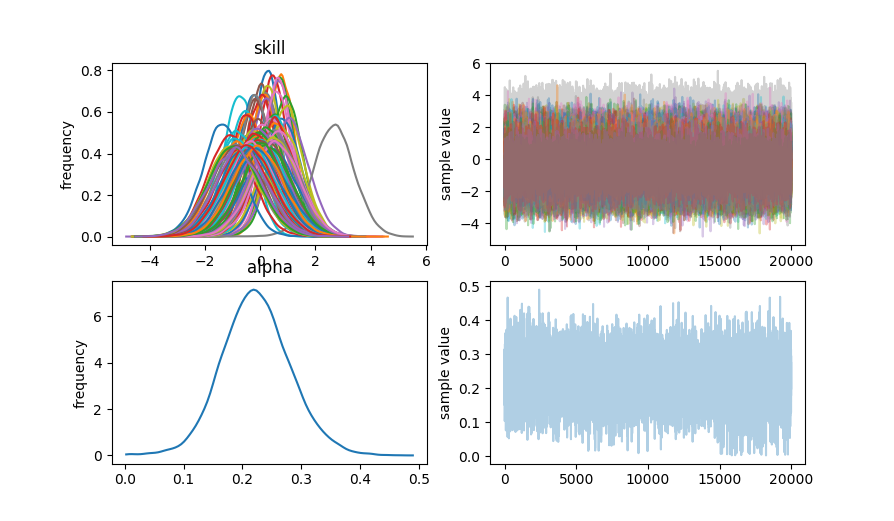

In [21]:
fit.plot();

In [22]:
skill = fit.extract()['skill']

skill_mean = skill.mean(axis=0)

ranking = pd.concat([df.team1_id, df.team1_name], axis=1).drop_duplicates()

ranking['skill'] = ranking.team1_id.apply(lambda x: skill_mean[teams.index(x)])

ranking.sort_values('skill', ascending=False)

team1_id      team1_name     skill
2298419     4863           TyLoo  2.651774
2296708     6134         Kinguin  1.052361
2293932     5310     HellRaisers  0.930492
2297499     6290      Luminosity  0.929667
2303118     7010       Immortals  0.776489
2304443     7175          Heroic  0.765517
2294037     5378      Virtus.pro  0.754900
2293957     4991          fnatic  0.694923
2294387     4608   Natus Vincere  0.676057
2293970     5422        dignitas  0.661340
2300627     4869            ENCE  0.659795
2295140     5988        FlipSid3  0.608685
2303282     7020          Spirit  0.590585
2304318     7169  fnatic Academy  0.555252
2294043     5284           Titan  0.553278
2301236     4688         Epsilon  0.548829
2298301     6301          Splyce  0.547409
2298216     6386       Winterfox  0.531873
2297228     6226      E-frag.net  0.513341
2303591     5680       Athletico  0.461250
2298674     6418      KoN Sweden  0.455054
2293960     4411             NiP  0.453491
2298004     5005      compLexity  0.449696
2307475     7557         Misfits  0.385514
2300446     6651          Gambit  0.357714
2294129     5991          EnVyUs  0.246868
2306487     7397         Outlaws  0.239249
2302203     6474     MVP Project  0.235737
2301338     6773     VG.CyberZen  0.216781
2294041     4494     mousesports  0.216044
...          ...             ...       ...
2304736     7145          Tengri -0.212982
2294272     5996             TSM -0.216456
2296945     6137              SK -0.254663
2298675     6420     KoN Finland -0.293895
2298673     6417     KoN Denmark -0.297269
2301313     6774       Signature -0.313144
2295913     6132          Method -0.346849
2301987     6908            FIVE -0.386902
2302269     6762            Bpro -0.408697
2302834     6807           Alpha -0.415030
2300964     6673             NRG -0.427576
2306010     7331       iGame.com -0.472349
2299530     6468          Legacy -0.477132
2294431     5293     AVANT GARDE -0.494015
2294035     5395           PENTA -0.496036
2297307     6211       Renegades -0.544338
2302231     6899             LGD -0.613145
2302779     4865            New4 -0.653453
2302373     6502    Born Of Fire -0.713130
2294209     5973          Liquid -0.758159
2300696     4602         Tricked -0.790728
2305468     4803         iNation -0.828394
2299969     6407           DenDD -0.839154
2302727     5412           eSuba -0.880071
2295479     4791        Immunity -0.891438
2297910     5258             nxl -0.949574
2300941     6724     Preparation -0.951242
2303697     7018     DarkPassage -0.976150
2303082     6896           PRIDE -1.082690
2300945     6736        Selfless -1.340946

[85 rows x 3 columns]

In [23]:
df_test['pred'] = -1

In [25]:
for k, row in df_test.iterrows():
    df_test.loc[k, 'pred'] = skill[:, teams.index(row.team1_id)].mean() > skill[:, teams.index(row.team2_id)].mean()

In [26]:
df_test['true'] = df_test.team1_rounds > df_test.team2_rounds

In [27]:
(df_test.pred == df_test.true).mean()

0.49822485207100592

In [28]:
df_test.true.mean()

0.52544378698224847